In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS,Logit
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.stats import *

/home/users/magu/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
dataset='all_beta_center_p001_20190530'

# phenotypes to analyze
phe_codes=['INI21001','HC221','HC294','HC326']

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
scores=reduce(lambda x,y: pd.merge(x,y,left_index=True,right_index=True),
              map(lambda phe: pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/PRS/all_pop/'+
                                               dataset+'/'+phe+'_PRS.profile', sep='\s+',
                                            usecols=['IID','SCORESUM'],
                                            index_col='IID').rename(columns={'SCORESUM':phe+'_PRS'}),
                  phe_codes))
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9)

# analysis populations
wbr=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                      'ukb24983_white_british.phe').iloc[:,0].tolist())
nbw=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                      'ukb24983_non_british_white.phe').iloc[:,0].tolist())

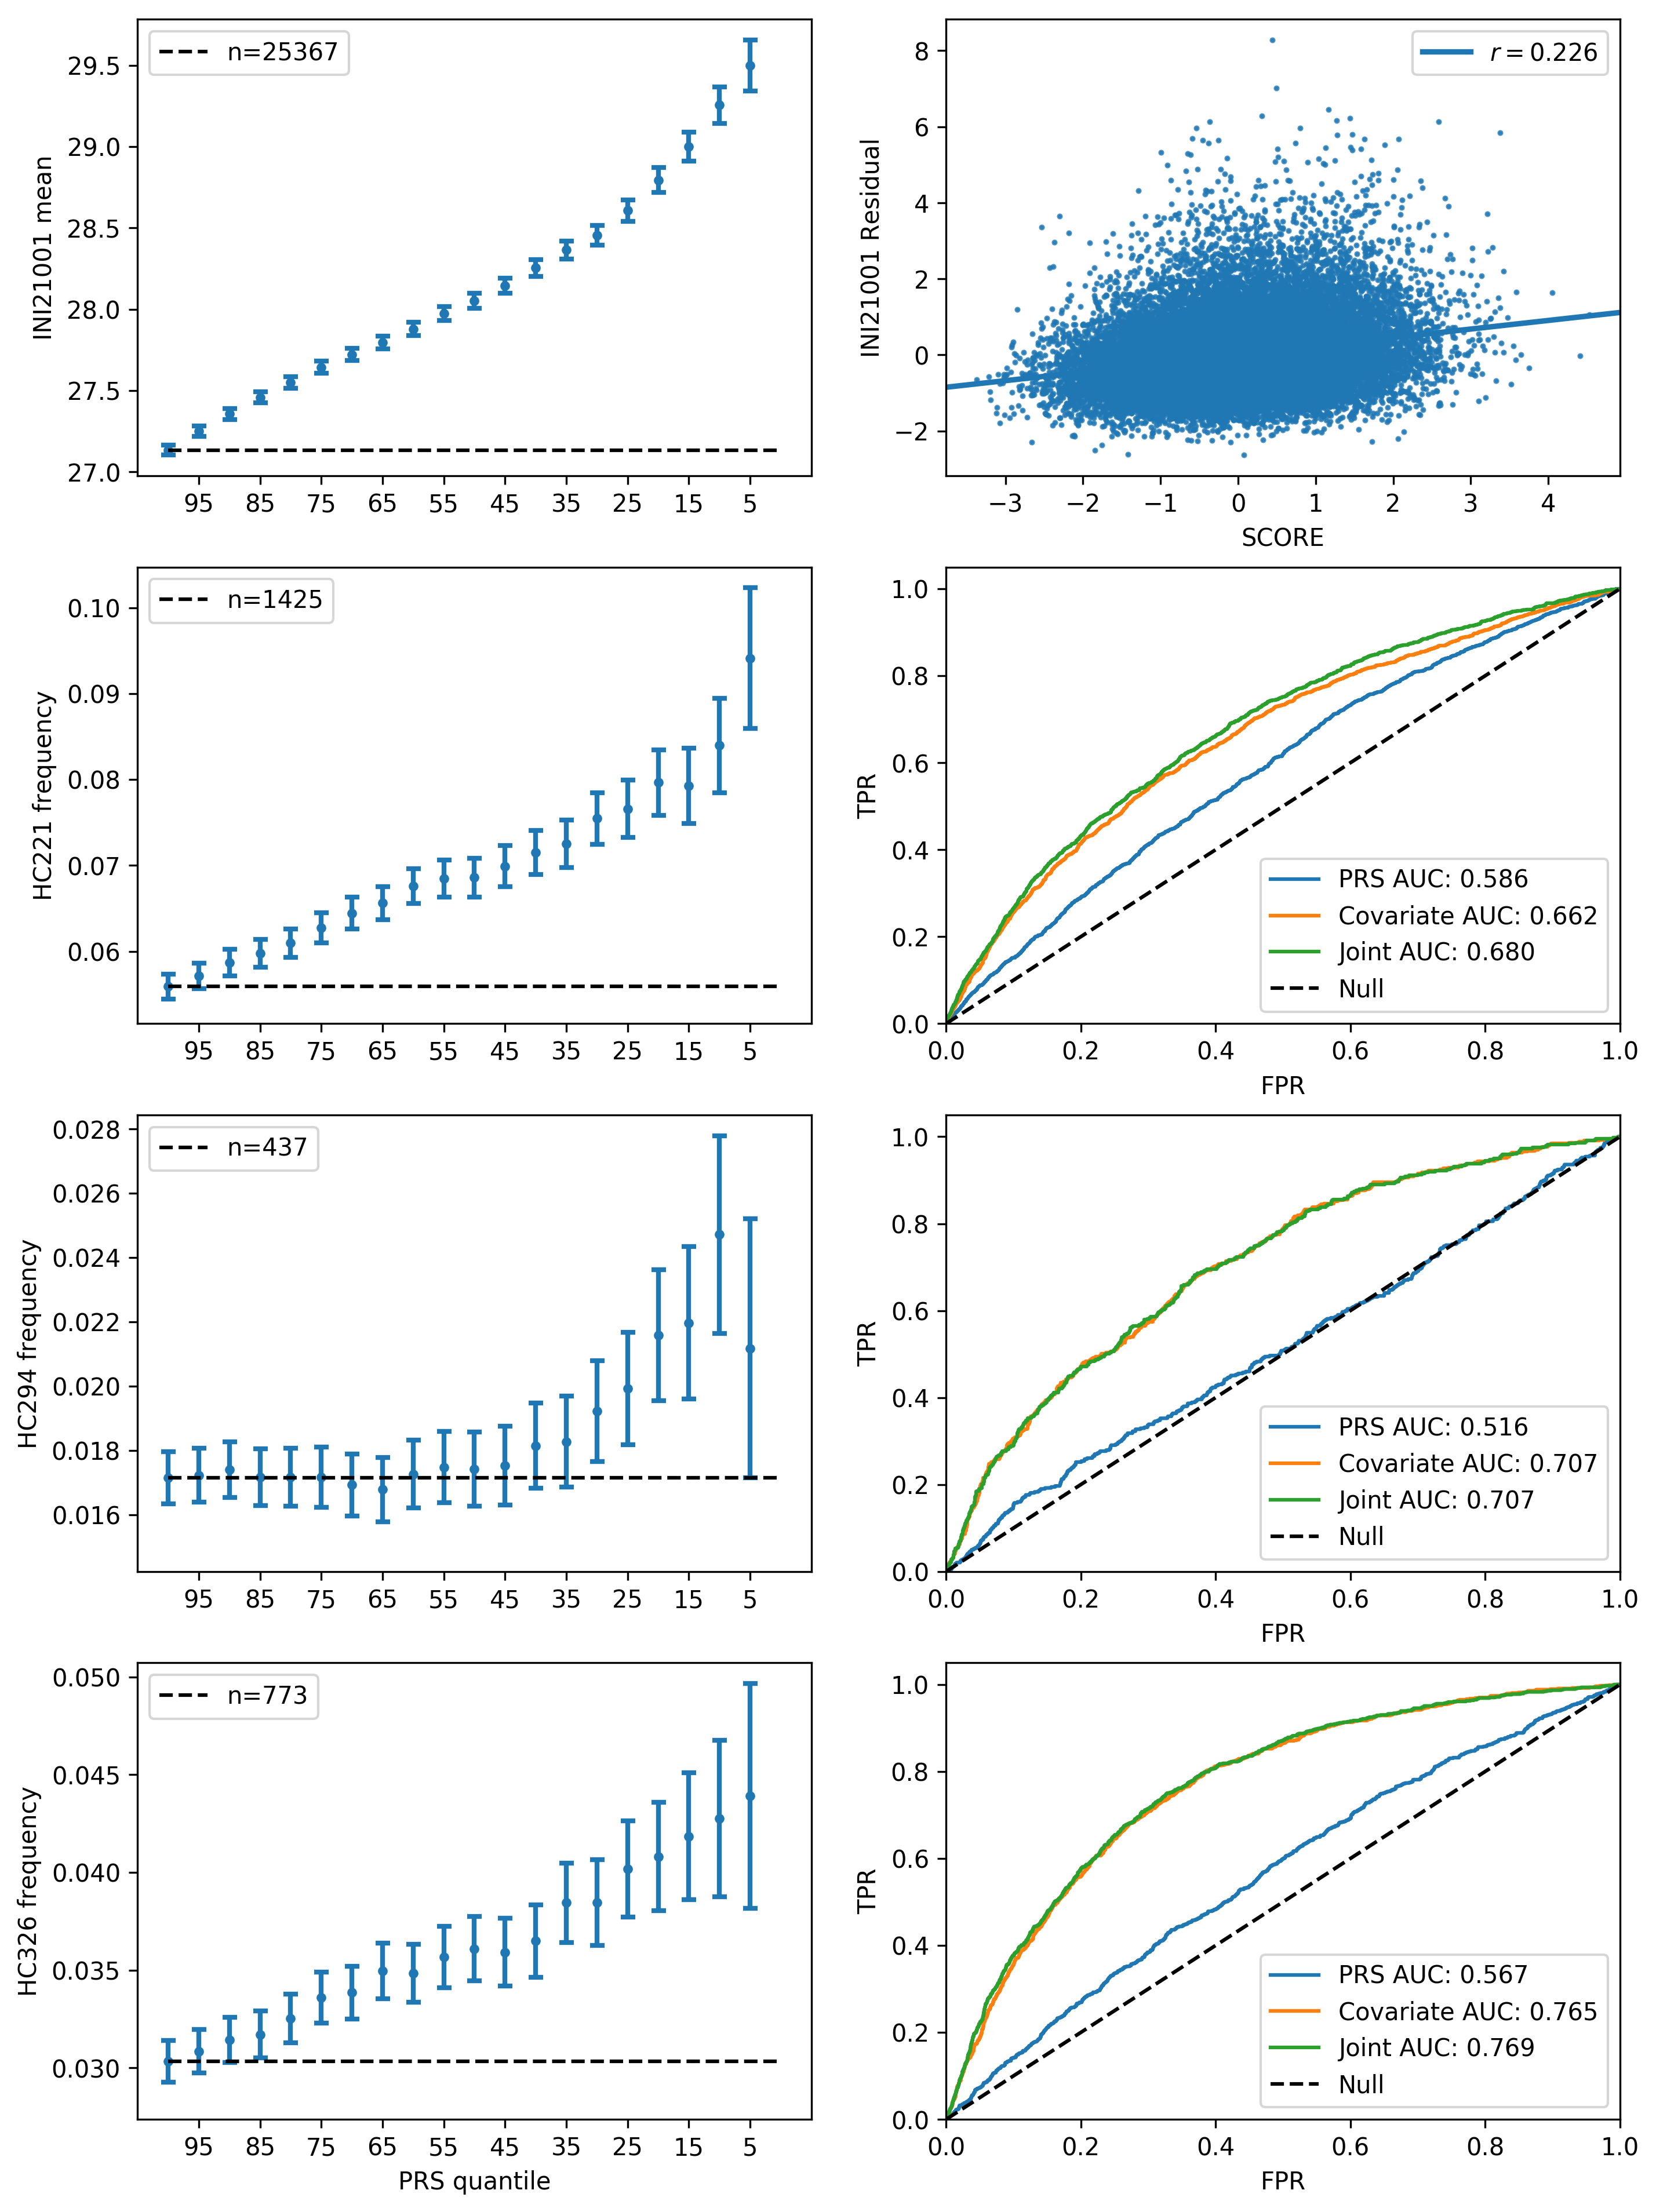

In [13]:
width = 2
# initialize plot objects
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
plt.figure(figsize=(5*width + 1, 4*len(phe_codes)), dpi=300)
for i,phe_code in enumerate(phe_codes):
    plots[2*i] = plt.subplot(len(phe_codes), width, width*i + 1)
    plots[(2*i)+1] = plt.subplot(len(phe_codes), width, width*i + 2)
    # scores and phenotypes
    df=phenos.loc[nbw,[phe_code]+covariate].dropna().merge(scores, left_index=True, right_index=True)
    n=df.shape[0]
    df['SCORE']=zscore(df[phe_code+'_PRS'])
    df.sort_values(by='SCORE',ascending=True,inplace=True)
    # this is to add an intercept in the regression models below
    df['1']=1
    covariates=covariate+['1']
    # start with check for bin/qt, and plotting distributions/AUC
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        df[phe_code]-=1 # remove plink binary format
        # loop over dPRS and these joint models
        cov_prs=Logit(df[phe_code],df[covariates]).fit(disp=0).fittedvalues
        jnt_prs=Logit(df[phe_code],df[covariates+['SCORE']]).fit(disp=0).fittedvalues
        for name,prs in zip(['PRS','Covariate','Joint'],[df['SCORE'],cov_prs,jnt_prs]):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(df[phe_code],prs)
            roc_auc=roc_auc_score(df[phe_code],prs)
            plots[(2*i)+1].plot(fpr,tpr,label=name+' AUC: '+'{:.3f}'.format(roc_auc))
        # add null line, axis labels
        plots[(2*i)+1].plot([0, 1],[0, 1],'k--',label='Null')
        plots[(2*i)+1].legend()
        plots[(2*i)+1].set_xlim([0.0, 1.0])
        plots[(2*i)+1].set_ylim([0.0, 1.05])
        plots[(2*i)+1].set_ylabel('TPR')
        plots[(2*i)+1].set_xlabel('FPR')
    else:
        is_bin=False
        # plot correlation with dPRS and residual phenotype
        resid=OLS(df[phe_code],df[covariates]).fit(disp=0).resid_pearson
        sns.regplot(x=df['SCORE'],y=resid,ax=plots[(2*i)+1],scatter_kws={'s':2})
        plots[(2*i)+1].set_ylabel(phe_code+' Residual')
        plots[(2*i)+1].legend(['$r=$'+'{:.3f}'.format(pearsonr(resid,df['SCORE'])[0])])
    # now do quantile plot with modified (only if binary) phenotype
    nq=20
    plots[2*i].scatter(np.arange(nq), [df.iloc[q*n/nq:,:][phe_code].mean() for q in range(nq)], s=9)
    plots[2*i].errorbar(x=np.arange(nq),
                        y=[df.iloc[q*n/nq:,:][phe_code].mean() for q in range(nq)],
                        yerr=[df.iloc[q*n/nq:,:][phe_code].std()/(((nq-q)*n/nq)**0.5) for q in range(nq)],
                        ls='none', capsize=3, elinewidth=2, markeredgewidth=2)
    # labels
    plots[2*i].set_ylabel(phe_code+' {}'.format('frequency' if is_bin else 'mean'))
    plots[2*i].set_xticks(np.arange(1,nq+1,2))
    plots[2*i].set_xticklabels([100*q/nq for q in reversed(range(1,nq+1,2))])
    plots[2*i].plot([0,nq],[df[phe_code].mean(),df[phe_code].mean()],'k--')
    plots[2*i].legend(['n={}'.format(int(df[phe_code].sum()) if is_bin else n)])
    
    # add x-axis labels at the very end
    if i==len(phe_codes)-1:
        plots[(2*i)].set_xlabel('PRS quantile')
    else:
        plots[(2*i)].set_xlabel('')
            
plt.show()